In [1]:
import copy
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from scipy.stats import mode
from sklearn.metrics import jaccard_score
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

In [2]:
def k_means(X, n_centroids, steps):
    n_x = X.shape[0]
    P = np.zeros(n_x)
    P_prev = np.zeros_like(P)
    
    C = np.asarray([X[i] for i in np.random.choice(np.arange(X.shape[0]), size=n_centroids, replace=False)])
    C_prev = np.zeros_like(C)
    for _ in range(steps):
        D = np.zeros((n_x, n_centroids))
        for i in range(n_x):
            D[i] = [d(X[i], C[j]) for j in range(n_centroids)]
            min_Di = np.where(D[i] == np.amin(D[i]))[0]
            P[i] = min_Di[0]
        for j in range(n_centroids):
            if (np.where(P == j)[0].shape == 0):
                C.delete(j)
                n_centroides -=1
            C[j] = np.sum(X[np.where(P == j)], axis=0) / np.where(P == j)[0].shape
        if np.array_equal(P, P_prev) or np.array_equal(C, C_prev):
            return P, C
        P_prev = copy.copy(P)
        C_prev = copy.copy(C) 
    return P, C

d = lambda X, C: math.sqrt(np.sum([(x - c)**2 for x, c in zip(X, C)]))

In [3]:
iris = datasets.load_iris()
X = iris.data
y_true = iris.target
n_centroids = len(np.unique(y_true))
steps = 100
y_pred, C = k_means(X, n_centroids, steps)

In [4]:
def find_perm(clusters, Y_real, Y_pred):
    perm = []
    for i in range(clusters):
        idx = Y_pred == i
        new_label = mode(Y_real[idx])[0][0]
        perm.append(new_label)
    return [perm[int(label)] for label in Y_pred]

y_pred_perm = find_perm(n_centroids, y_true, y_pred)
print(y_pred)
print(np.asarray(y_pred_perm))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 1. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 2. 2. 1.
 2. 1. 2. 1. 2. 2. 1. 1. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 1. 2. 2. 2. 1. 2.
 2. 2. 1. 2. 2. 1.]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]


In [5]:
print(jaccard_score(y_true, y_pred_perm, average=None)) 

[1.         0.75       0.69230769]


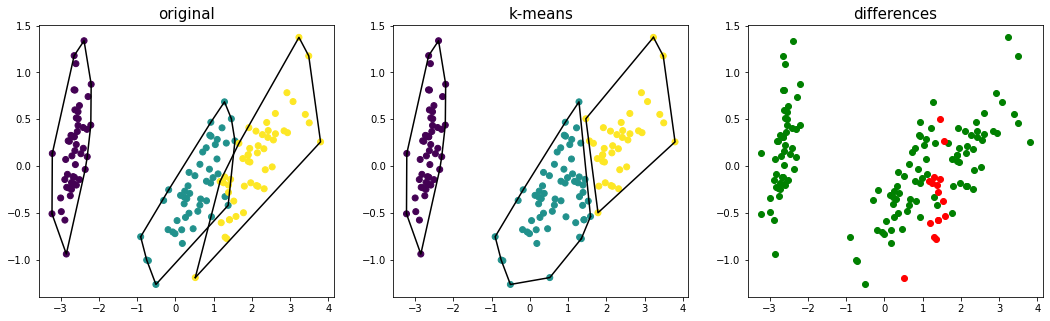

In [6]:
def visualize_pca_2d(X, y_true, y_pred):
    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(X)
    
    fig = plt.figure(figsize = (18, 5))
    ax1 = fig.add_subplot(1,3,1) 
    ax1.set_title('original', fontsize = 15)
    ax1.scatter(principalComponents[:, 0], principalComponents[:, 1], c=y_true)
    for i in np.unique(y_true):
        points = principalComponents[np.where(y_true == i)]
        hull = ConvexHull(points)
        ax1.plot(points[hull.vertices,0], points[hull.vertices,1], 'k')
        last_first = [[points[hull.vertices[-1],0], points[hull.vertices[0],0]], [points[hull.vertices[-1],1], points[hull.vertices[0],1]]]
        ax1.plot(last_first[0], last_first[1], 'k')
        
    ax2 = fig.add_subplot(1,3,2) 
    ax2.set_title('k-means', fontsize = 15)
    ax2.scatter(principalComponents[:, 0], principalComponents[:, 1], c=y_pred)
    for i in np.unique(y_pred):
        points = principalComponents[np.where(y_pred == i)]
        if len(points) >= 3:
            hull = ConvexHull(points)
            ax2.plot(points[hull.vertices,0], points[hull.vertices,1], 'k')
            last_first = [[points[hull.vertices[-1],0], points[hull.vertices[0],0]], [points[hull.vertices[-1],1], points[hull.vertices[0],1]]]
            ax2.plot(last_first[0], last_first[1], 'k')

    ax3 = fig.add_subplot(1,3,3) 
    ax3.set_title('differences', fontsize = 15)
    ax3.scatter(principalComponents[np.where(y_true==y_pred), 0], principalComponents[np.where(y_true==y_pred), 1], c='g')
    ax3.scatter(principalComponents[np.where(y_true!=y_pred), 0], principalComponents[np.where(y_true!=y_pred), 1], c='r')
    plt.show()

visualize_pca_2d(X, y_true, y_pred_perm)

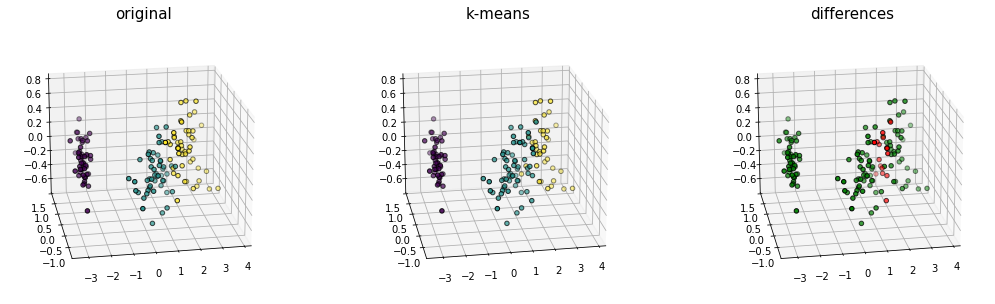

In [7]:
def visualize_pca_3d(X, y_true, y_pred):
    pca = PCA(n_components=3)
    principalComponents = pca.fit_transform(X)
    
    fig = plt.figure(figsize=(18, 5))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.set_title('original', fontsize = 15)
    ax1.scatter(principalComponents[:, 0], principalComponents[:, 1], principalComponents[:, 2], c = y_true, edgecolor='k')
    ax1.view_init(elev=20, azim=260)
    
    ax2 = fig.add_subplot(132, projection='3d')
    ax2.set_title('k-means', fontsize = 15)
    ax2.scatter(principalComponents[:, 0], principalComponents[:, 1], principalComponents[:, 2], c = y_pred, edgecolor='k')
    ax2.view_init(elev=20, azim=260)
    
    ax3 = fig.add_subplot(133, projection='3d')
    ax3.set_title('differences', fontsize = 15)
    ax3.scatter(principalComponents[np.where(y_true==y_pred), 0], principalComponents[np.where(y_true==y_pred), 1], principalComponents[np.where(y_true==y_pred), 2], c = 'g', edgecolor='k')
    ax3.scatter(principalComponents[np.where(y_true!=y_pred), 0], principalComponents[np.where(y_true!=y_pred), 1], principalComponents[np.where(y_true!=y_pred), 2], c = 'r', edgecolor='k')
    ax3.view_init(elev=20, azim=260)
    plt.show()
    
visualize_pca_3d(X, y_true, y_pred_perm)

sklearn.cluster.KMeans_____________________________________________________
y predicted permutated: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]
jaccard score:  [1.         0.75       0.69230769]


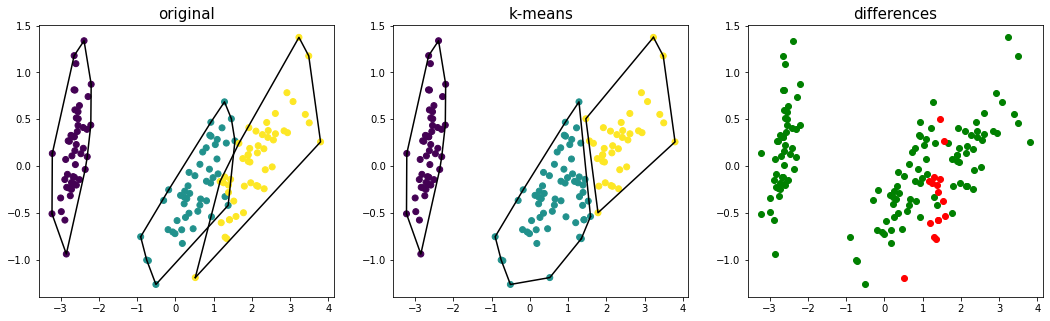

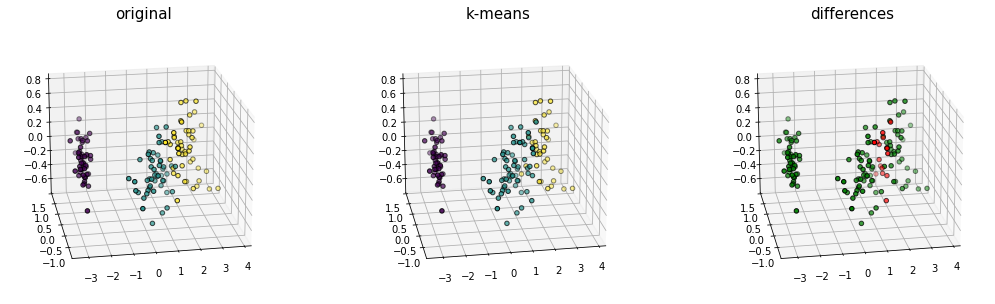

In [8]:
def all_functions(method, X, y_true, n_centroids, y_pred):
    print(method + "_____________________________________________________")
    y_pred_perm = find_perm(n_centroids, y_true, y_pred)
    print("y predicted permutated: \n", np.asarray(y_pred_perm))
    print("jaccard score: ", jaccard_score(list(y_true), list(y_pred_perm), average=None))
    visualize_pca_2d(X, y_true, y_pred_perm)
    visualize_pca_3d(X, y_true, y_pred_perm)
            
kmeans = KMeans(n_clusters=n_centroids).fit(X)
y_pred = kmeans.labels_
all_functions("sklearn.cluster.KMeans", X, y_true, n_centroids, y_pred)

sklearn.mixture.GaussianMixture_____________________________________________________
y predicted permutated: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]
jaccard score:  [1.         0.75       0.69230769]


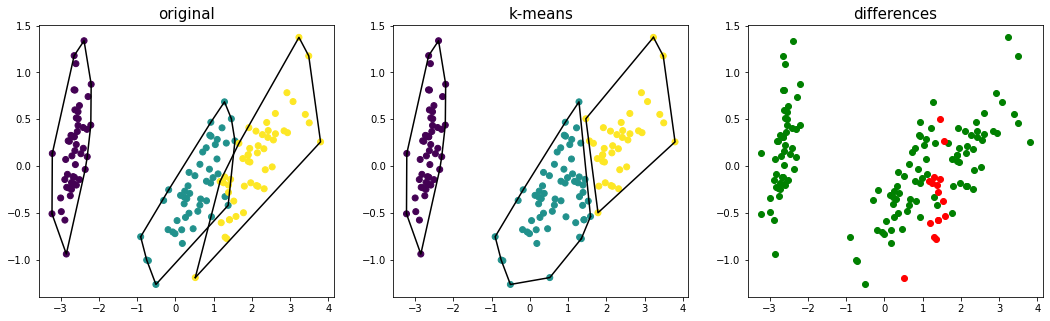

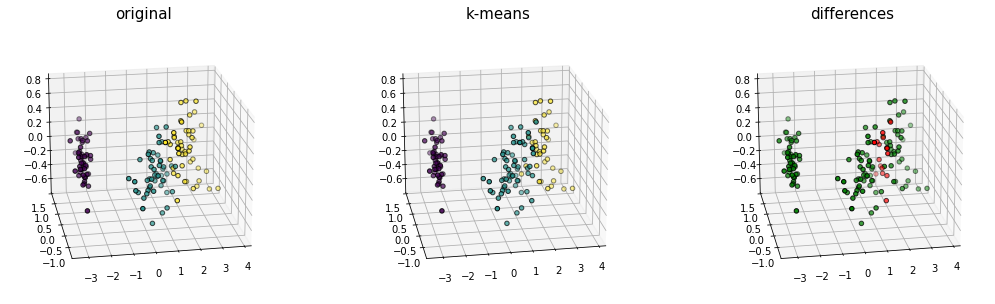

In [9]:
y_pred = GaussianMixture(n_components=n_centroids, covariance_type='spherical').fit_predict(X)
all_functions("sklearn.mixture.GaussianMixture", X, y_true, n_centroids, y_pred)

sklearn.cluster.AgglomerativeClustering(single)_____________________________________________________
y predicted permutated: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1]
jaccard score:  [1.         0.51020408 0.04      ]


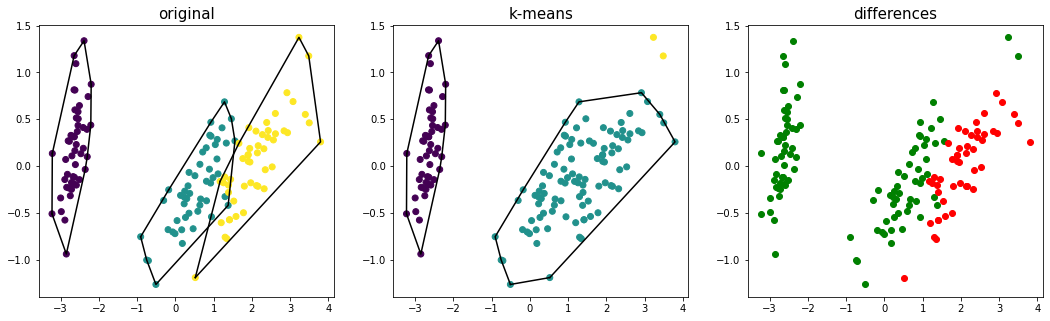

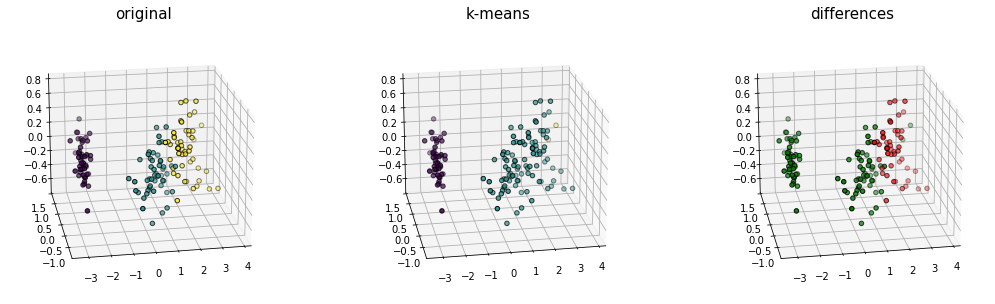

sklearn.cluster.AgglomerativeClustering(average)_____________________________________________________
y predicted permutated: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]
jaccard score:  [1.      0.78125 0.72   ]


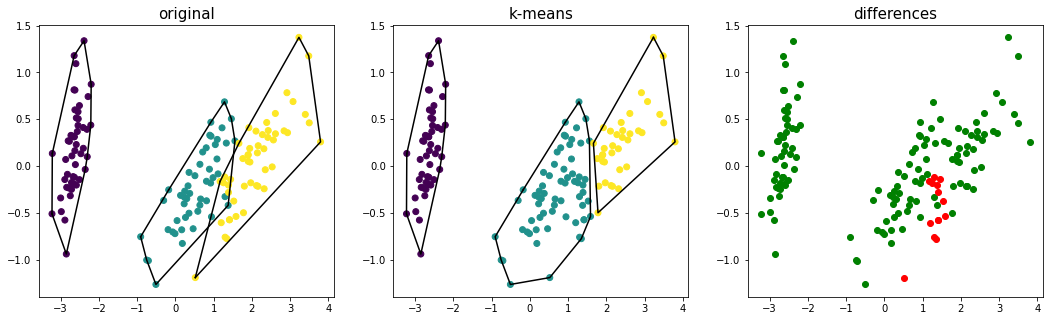

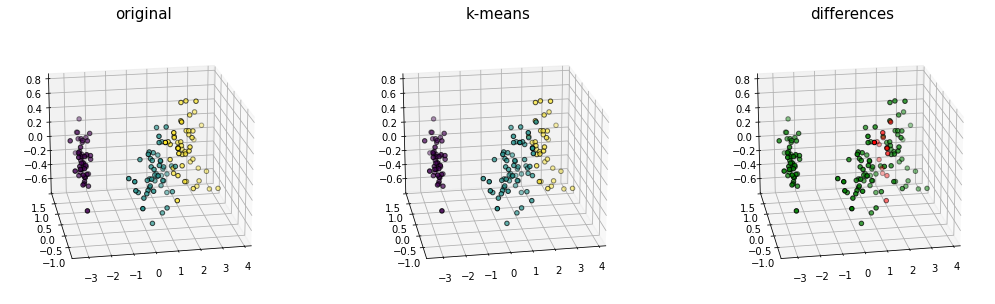

sklearn.cluster.AgglomerativeClustering(complete)_____________________________________________________
y predicted permutated: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 2 2 1 2 1 2 1 2 1 1 1 1 2 1 2 1 1 2 1 2 1 2 2
 2 2 2 2 2 1 1 1 1 2 1 2 2 2 1 1 1 2 1 1 1 1 1 2 1 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
jaccard score:  [1.         0.52941176 0.67123288]


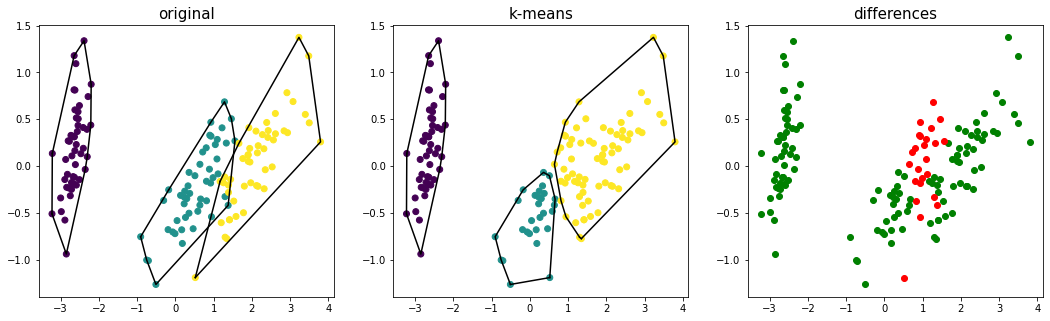

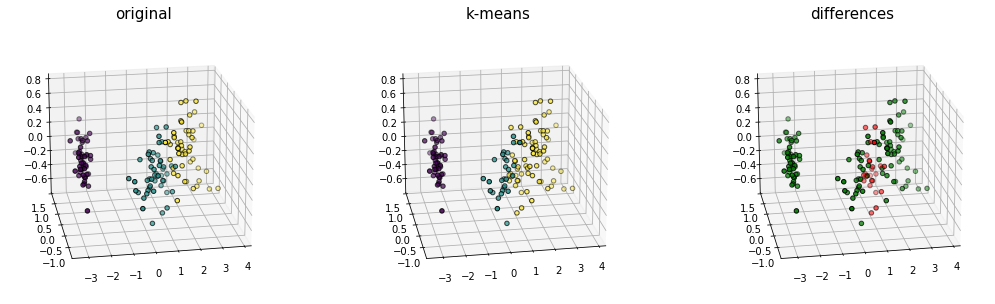

sklearn.cluster.AgglomerativeClustering(ward)_____________________________________________________
y predicted permutated: 
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 1 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]
jaccard score:  [1.         0.75384615 0.68627451]


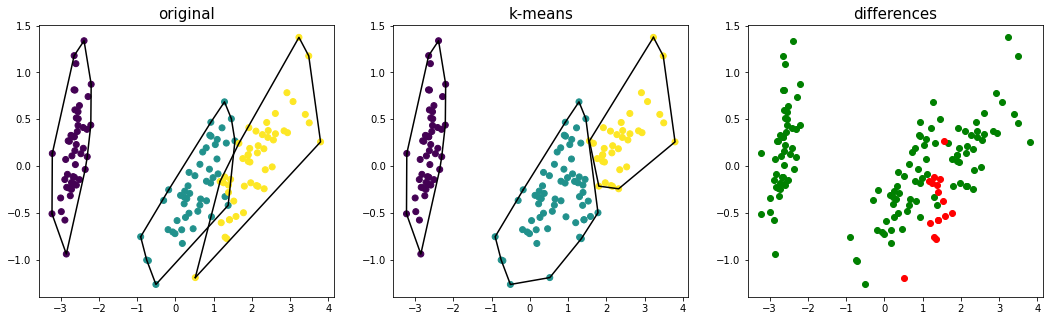

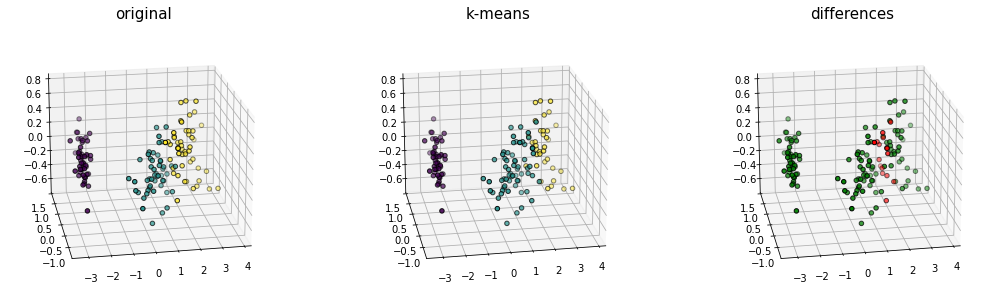

In [10]:
from sklearn.cluster import AgglomerativeClustering

for linkage_criterion in ['single', 'average', 'complete', 'ward']:
    clustering = AgglomerativeClustering(n_clusters=n_centroids, linkage=linkage_criterion).fit(X)
    y_pred = clustering.labels_
    all_functions("sklearn.cluster.AgglomerativeClustering("+linkage_criterion+")", X, y_true, n_centroids, y_pred)

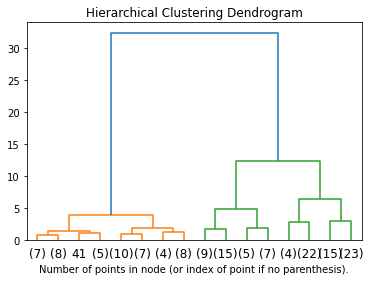

In [11]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    dendrogram(linkage_matrix, **kwargs)

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

k-means (own implementation)_____________________________________________________
y predicted permutated: 
 [5 5 2 5 5 5 5 2 2 5 5 1 2 4 4 3 1 5 2 2 1 1 5 1 3 0 0 1 5 5 3 5 5 1 2 5 5
 1 2 3 3 1 3 1 5 5 3 5 5 5 5 3 0 3 5 5 1 1 1 1 2 2 2 5 5 5 2 5 5 5 5 1 3 2
 2 1 2 4 1 1 2 4 2 1 1 4 2 1 3 0 0 0 2 1 5 1 1 3 5 4 1]
jaccard score:  [0.66666667 0.8        0.68421053 0.66666667 0.6        0.80487805
 0.        ]


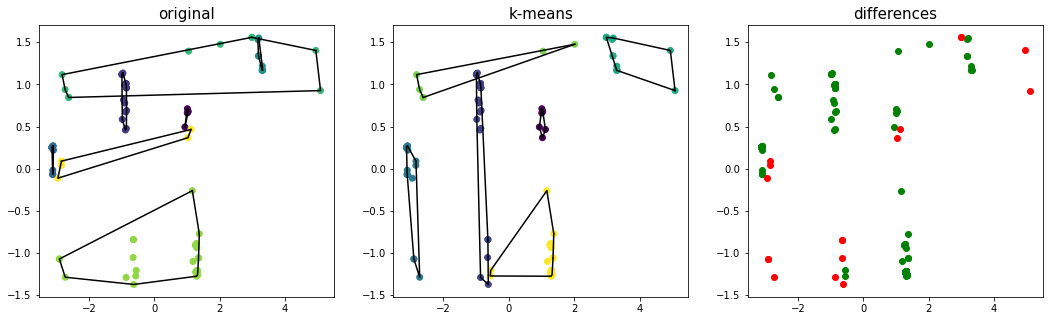

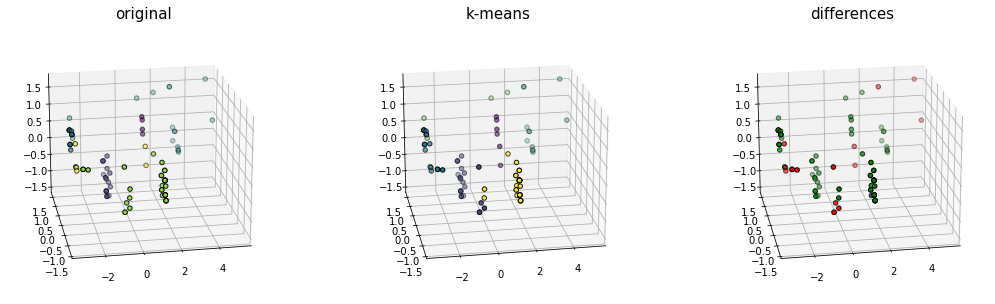

sklearn.cluster.KMeans_____________________________________________________
y predicted permutated: 
 [5 5 2 5 5 5 5 2 2 5 5 1 2 2 0 4 1 5 2 2 1 1 5 1 3 0 0 5 5 5 3 5 5 1 2 5 5
 1 2 3 3 1 3 1 5 5 4 5 5 5 5 3 0 4 5 5 1 1 1 1 2 2 2 5 5 5 2 5 5 5 5 1 4 2
 2 5 2 2 1 1 2 2 2 1 5 0 2 1 3 0 0 0 2 5 5 1 5 3 5 2 1]
jaccard score:  [0.5        1.         0.56521739 1.         0.4        0.92682927
 0.        ]


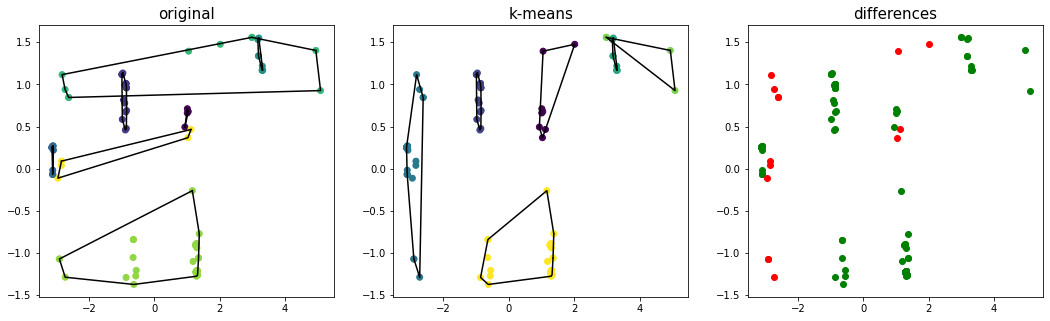

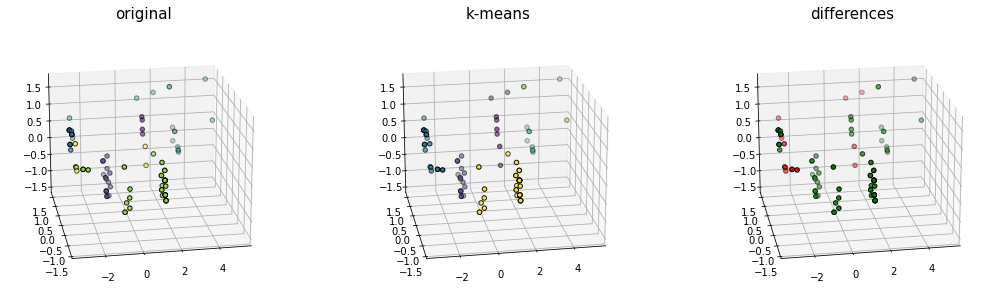

sklearn.mixture.GaussianMixture_____________________________________________________
y predicted permutated: 
 [5 5 2 5 5 5 5 2 2 5 5 1 2 4 0 3 1 5 2 2 1 1 5 1 3 0 0 5 5 5 3 5 5 1 2 5 5
 1 2 3 3 1 3 1 5 5 3 5 5 5 5 3 0 3 5 5 1 1 1 1 2 2 2 0 5 5 2 5 5 5 5 1 3 2
 2 5 2 4 1 1 2 4 2 1 5 3 2 1 3 0 0 0 2 5 5 1 5 3 5 4 1]
jaccard score:  [0.5        1.         0.68421053 0.61538462 0.4        0.90243902
 0.        ]


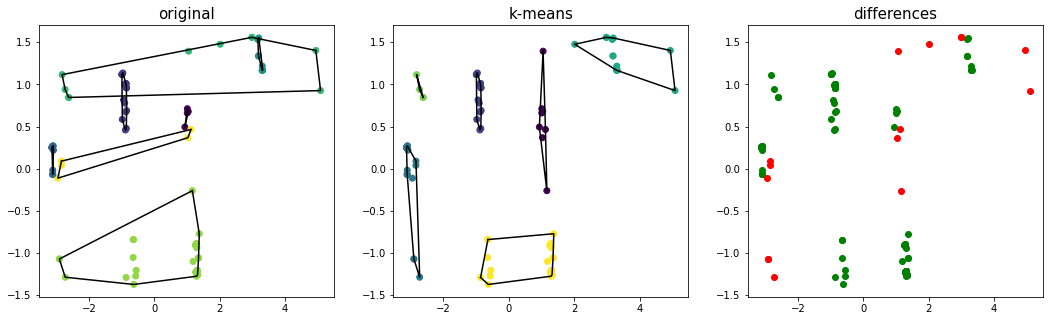

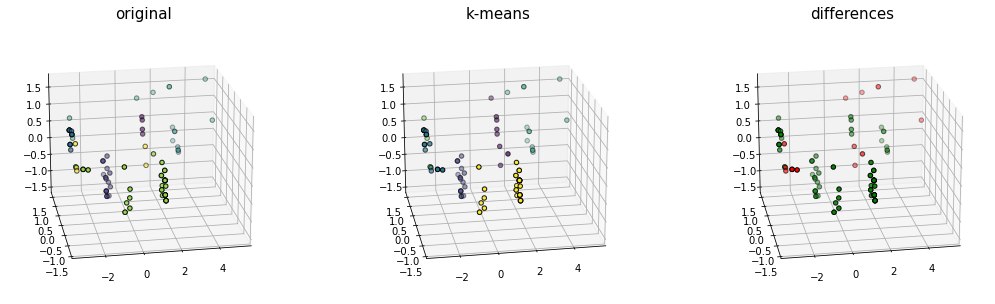

In [11]:
zoo_df = pd.read_csv('zoo.csv')
zoo_df = zoo_df.drop(['animal'], axis=1)
X = zoo_df.loc[:, zoo_df.columns != 'type'].values.astype(int)

y_true = np.ravel(zoo_df.loc[:,['type']].values)
y_true_unique = np.unique(y_true)
for i, iy in enumerate(y_true):
    for j, label in enumerate(y_true_unique):
        if iy == label:
            y_true[i] = j

n_centroids = len(np.unique(y_true))
y_pred, C = k_means(X, n_centroids, steps)
all_functions("k-means (own implementation)", X, y_true, n_centroids, y_pred)

kmeans = KMeans(n_clusters=n_centroids).fit(X)
y_pred = kmeans.labels_
all_functions("sklearn.cluster.KMeans", X, y_true, n_centroids, y_pred)

y_pred = GaussianMixture(n_components=n_centroids, covariance_type='spherical').fit_predict(X)
all_functions("sklearn.mixture.GaussianMixture", X, y_true, n_centroids, y_pred)

sklearn.cluster.AgglomerativeClustering(single)_____________________________________________________
y predicted permutated: 
 [5 5 2 5 5 5 5 2 2 5 5 1 2 4 5 5 1 5 2 2 1 1 5 1 5 5 5 5 5 5 5 5 5 1 2 5 5
 1 2 5 5 1 5 1 5 5 5 5 5 5 5 5 5 4 5 5 1 1 1 1 2 2 2 5 5 5 2 5 5 5 5 1 4 2
 2 5 2 4 1 1 2 4 2 1 5 5 2 1 5 5 5 5 2 5 5 1 5 5 5 4 1]
jaccard score:  [0.         1.         0.68421053 0.         0.6        0.6440678
 0.        ]


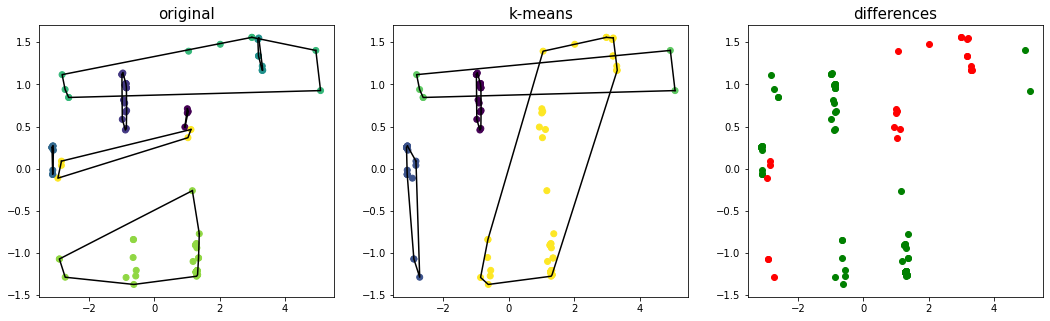

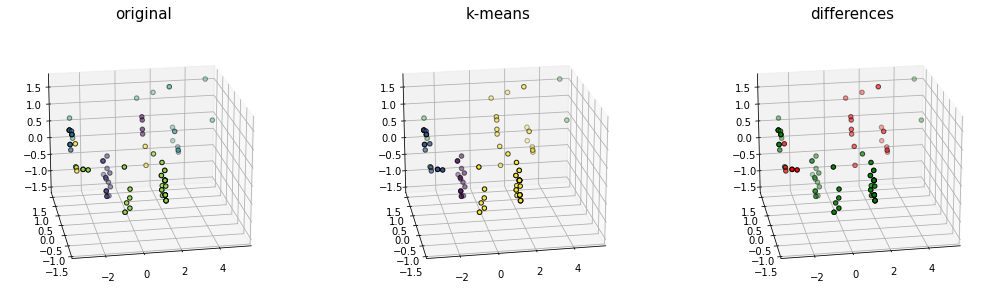

sklearn.cluster.AgglomerativeClustering(average)_____________________________________________________
y predicted permutated: 
 [5 5 2 5 5 5 5 2 2 5 5 1 2 4 3 3 1 5 2 2 1 1 5 1 3 5 5 5 5 5 3 5 5 1 2 5 5
 1 2 3 3 1 3 1 5 5 3 5 5 5 5 3 5 4 5 5 1 1 1 1 2 2 2 5 5 5 2 5 5 5 5 1 4 2
 2 5 2 4 1 1 2 4 2 1 5 3 2 1 3 5 5 5 2 5 5 1 5 3 5 4 1]
jaccard score:  [0.         1.         0.68421053 0.66666667 0.6        0.80851064
 0.        ]


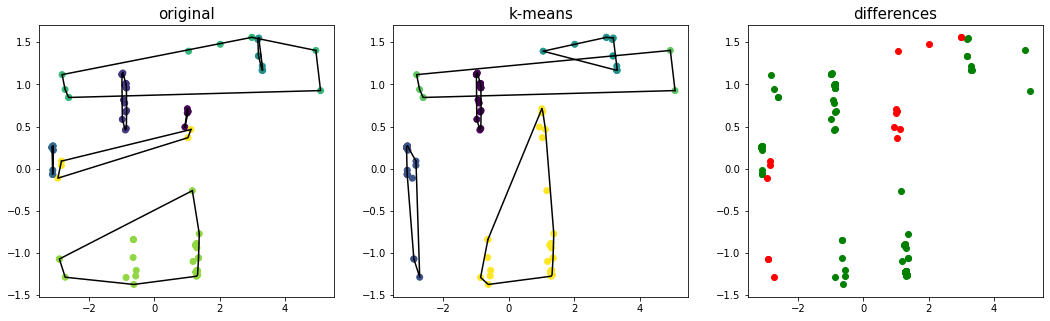

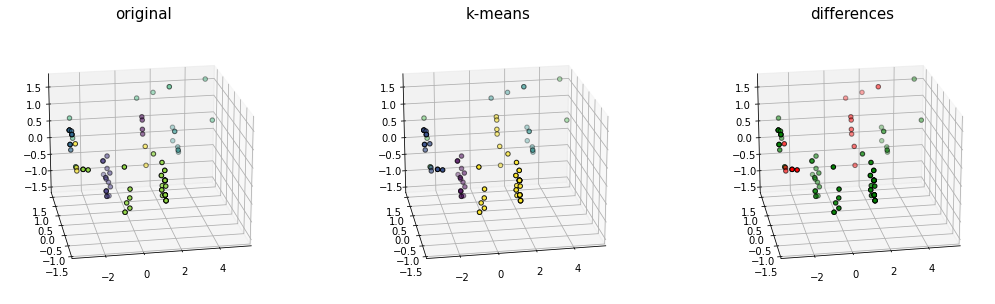

sklearn.cluster.AgglomerativeClustering(complete)_____________________________________________________
y predicted permutated: 
 [5 5 2 5 5 5 5 2 2 5 5 1 2 2 4 4 1 5 2 2 1 1 5 1 3 5 5 5 5 5 3 5 5 1 2 5 5
 1 2 3 3 1 3 1 5 5 4 5 5 5 5 3 5 4 5 5 1 1 1 1 2 2 2 5 5 5 2 5 5 5 5 1 4 2
 2 5 2 2 1 1 2 2 2 1 5 4 2 1 3 5 5 5 2 5 5 1 5 3 5 2 1]
jaccard score:  [0.         1.         0.56521739 1.         0.6        0.80851064
 0.        ]


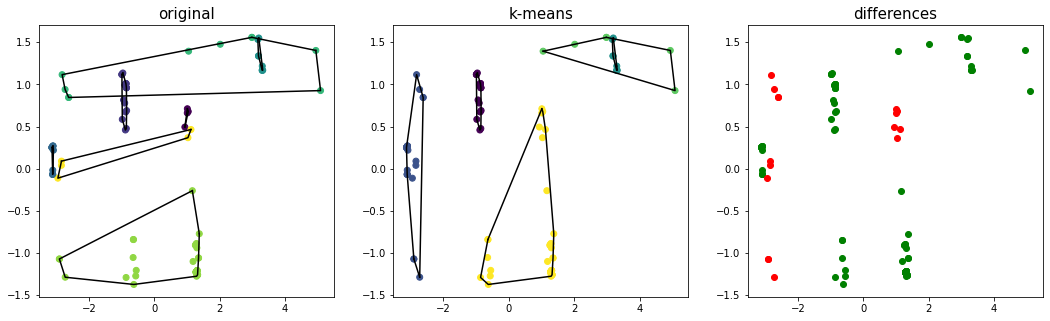

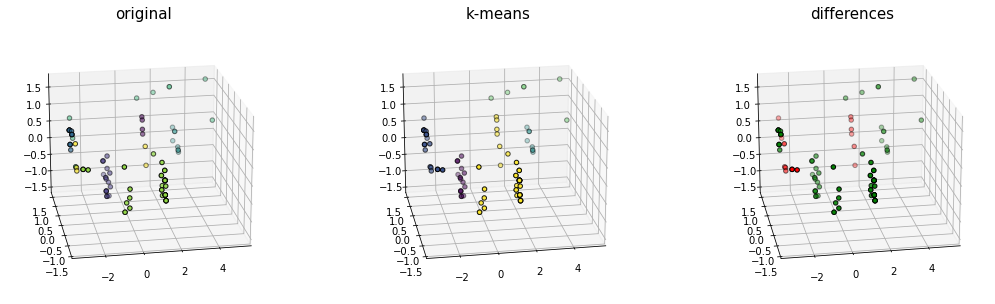

sklearn.cluster.AgglomerativeClustering(ward)_____________________________________________________
y predicted permutated: 
 [5 5 2 5 5 5 5 2 2 5 5 1 2 4 3 3 1 5 2 2 1 1 5 1 3 0 0 5 5 5 3 5 5 1 2 5 5
 1 2 3 3 1 3 1 5 5 3 5 5 5 5 3 0 3 5 5 1 1 1 1 2 2 4 0 5 5 2 5 5 5 5 1 3 2
 2 5 4 4 1 1 4 4 2 1 5 3 2 1 3 0 0 0 2 5 5 1 5 3 5 4 1]
jaccard score:  [0.57142857 1.         0.8125     0.57142857 0.30769231 0.90243902
 0.        ]


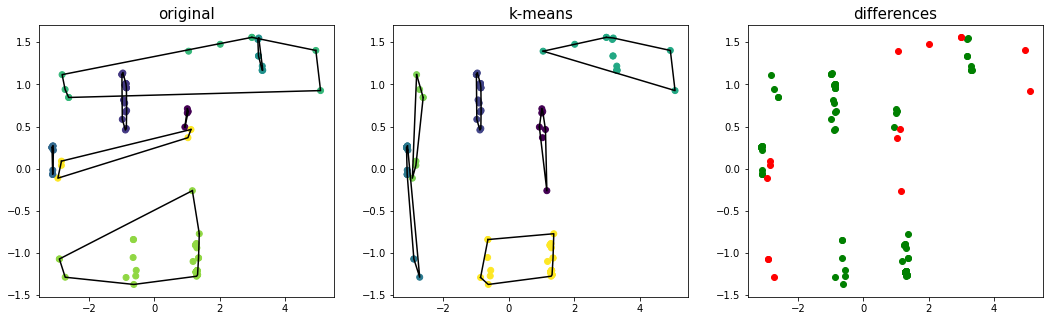

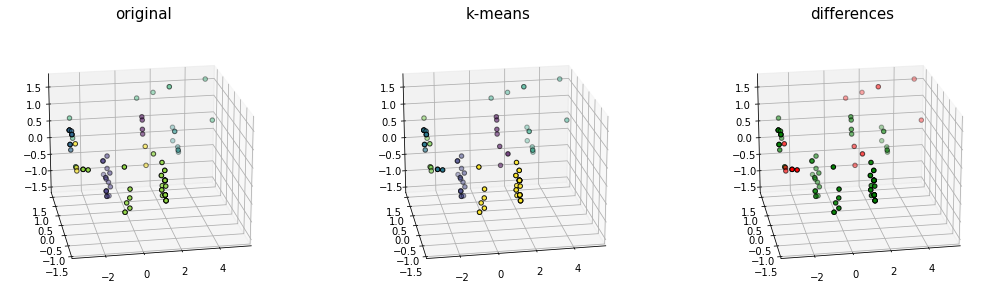

In [12]:
for linkage_criterion in ['single', 'average', 'complete', 'ward']:
    clustering = AgglomerativeClustering(n_clusters=n_centroids, linkage=linkage_criterion).fit(X)
    y_pred = clustering.labels_
    all_functions("sklearn.cluster.AgglomerativeClustering("+linkage_criterion+")", X, y_true, n_centroids, y_pred)

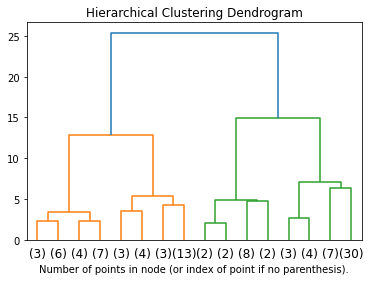

In [13]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()